In [46]:
# IPEDS lab
# Brady Setser & Ben Cuff
# 3/5/2025

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score,classification_report, accuracy_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline


```
1. How strongly does residency status impact the proportion of students paying in-state tuition across different institutions? Classification (Support Vector Machines - SVM)

Why It’s Interesting: Many students and families consider the type of institution when deciding on college affordability. Understanding whether tuition costs are heavily influenced by classification can help guide students in their decision-making.This question is particularly relevant to prospective college students and their families who are evaluating the financial implications of attending different types of institutions. By analyzing the impact of residency status on tuition costs, we can provide valuable insights that aid in making informed decisions about higher education options.

```

In [64]:
# Load datasets
# ic_df = pd.read_csv("IPEDS_data/ic2023.csv")  # Institutional Characteristics
sfa_df = pd.read_csv("IPEDS_data/sfa2223.csv")  # Student Financial Aid
# ic_df.head()
# sfa_df['SCFA12N'].dropna().describe() # – Percentage of students paying in-state tuition
# sfa_df['IGRNT_P'].dropna().describe() # – Percentage of students who are recieving scholarships/fellowships
uni_name = pd.read_csv("Datasets/question_2.csv")
uni_name = uni_name[['UnitID', 'Institution Name']]
merged_df = pd.merge(uni_name, sfa_df, right_on='UNITID', left_on='UnitID')
merged_df = merged_df[['Institution Name', 'SCFA12P', 'IGRNT_P']].dropna()
merged_df.head()

,Institution Name,SCFA12P,IGRNT_P
1,Arizona State University Campus Immersion,58.0,85.0
3,Arkansas State University,80.0,87.0
4,Auburn University,61.0,73.0
5,Augusta University,93.0,16.0
7,Ball State University,91.0,57.0


          SCFA12P     IGRNT_P
count  196.000000  196.000000
mean    76.642857   68.892857
std     18.242947   20.734061
min     16.000000    7.000000
25%     63.750000   55.750000
50%     80.000000   71.000000
75%     92.000000   86.000000
max    100.000000   99.000000


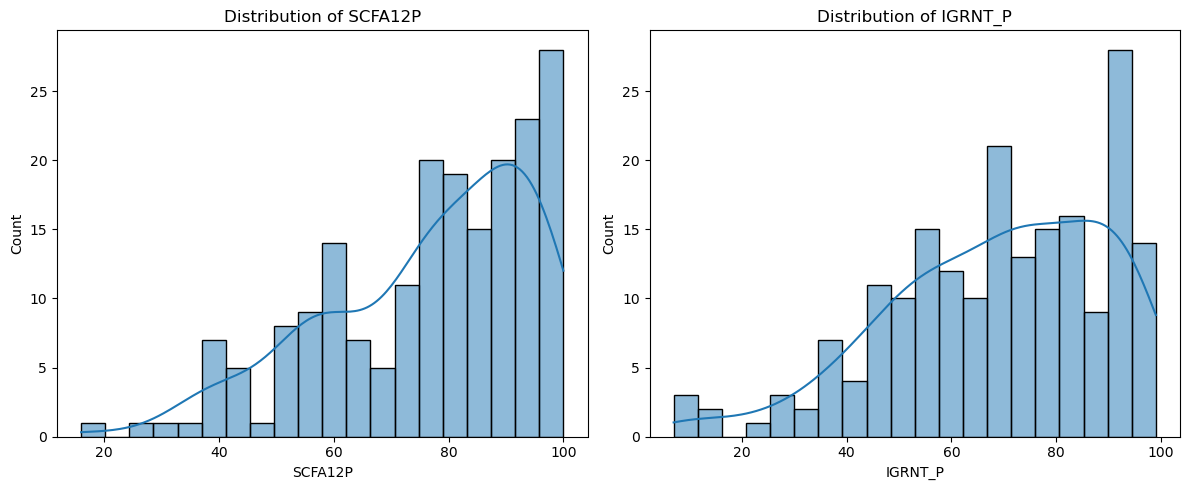

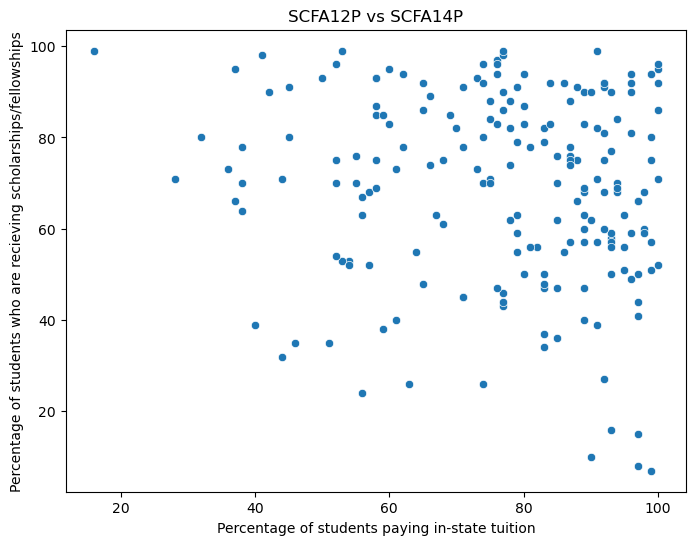

In [65]:
# Display basic statistics
print(merged_df.describe())
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(merged_df['SCFA12P'], kde=True, bins=20)
plt.title('Distribution of SCFA12P')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['IGRNT_P'], kde=True, bins=20)
plt.title('Distribution of IGRNT_P')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='SCFA12P', y='IGRNT_P', data=merged_df)
plt.title('SCFA12P vs SCFA14P')
plt.xlabel('Percentage of students paying in-state tuition')
plt.ylabel('Percentage of students who are recieving scholarships/fellowships')
plt.show()


```markdown
Justification: K-Means clustering is chosen because it is a straightforward and efficient unsupervised learning algorithm that partitions the data into k distinct clusters based on feature similarity. It is particularly useful for identifying patterns and grouping institutions with similar characteristics, such as the proportion of students paying in-state tuition and those receiving scholarships. By applying K-Means clustering, we can gain insights into the underlying structure of the data and identify distinct groups of institutions that share common financial aid characteristics.
```


c:\Users\18438\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


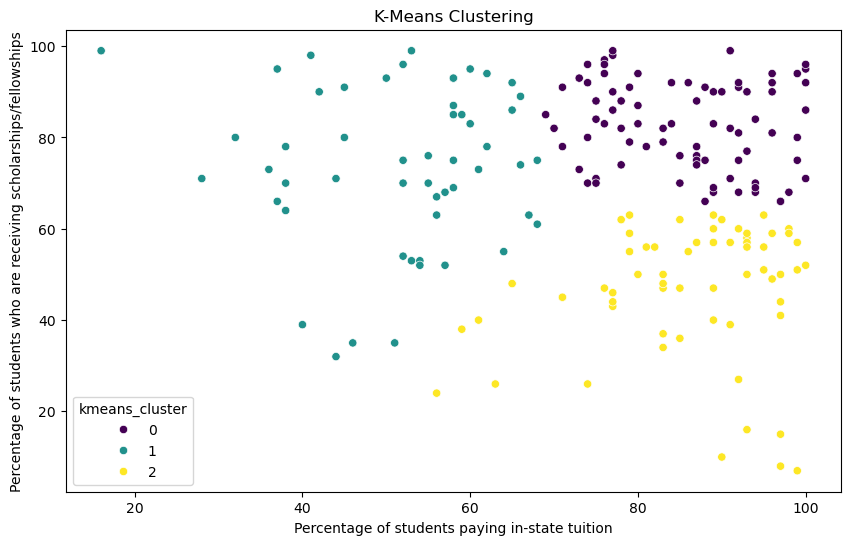

kmeans_cluster
0    81
2    62
1    53
Name: count, dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer

# Apply K-Means clustering
OMP_NUM_THREADS=1
kmeans = KMeans(n_clusters=3, random_state=1)
X = merged_df[['SCFA12P', 'IGRNT_P']]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_scaled = StandardScaler().fit_transform(X_imputed)
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
merged_df['kmeans_cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['SCFA12P'], y=merged_df['IGRNT_P'], hue=merged_df['kmeans_cluster'], palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Percentage of students paying in-state tuition')
plt.ylabel('Percentage of students who are receiving scholarships/fellowships')
plt.show()

# Display the number of institutions in each cluster
print(merged_df['kmeans_cluster'].value_counts())

In [67]:
# Check the unique cluster labels
unique_clusters = merged_df['kmeans_cluster'].unique()
print(f"Unique clusters: {unique_clusters}")

# Group by kmeans_cluster and print the first 10 entries of each group
grouped = merged_df.groupby('kmeans_cluster')

for cluster, group in grouped:
    print(f"Cluster {cluster}:")
    print(group[['Institution Name', 'SCFA12P', 'IGRNT_P']].head(10))
    print("\n")

Unique clusters: [1 0 2]
Cluster 0:
                              Institution Name  SCFA12P  IGRNT_P
3                    Arkansas State University     80.0     87.0
13  Bowling Green State University-Main Campus     89.0     90.0
19          California State University-Fresno     97.0     66.0
25                 Central Michigan University    100.0     95.0
31                  Cleveland State University     87.0     76.0
37                           CUNY City College     98.0     68.0
46                 Eastern Michigan University    100.0     92.0
49                 Florida Atlantic University     79.0     79.0
51            Florida International University     92.0     68.0
62                      Idaho State University     96.0     81.0


Cluster 1:
                                     Institution Name  SCFA12P  IGRNT_P
1           Arizona State University Campus Immersion     58.0     85.0
4                                   Auburn University     61.0     73.0
10                  

The clustering results reveal interesting patterns among the institutions based on the percentage of students paying in-state tuition (SCFA12P) and the percentage of students receiving scholarships/fellowships (IGRNT_P).

- **Cluster 0**: This cluster includes institutions with high percentages of students paying in-state tuition, often close to or at 100%, and relatively high percentages of students receiving scholarships. For example, Central Michigan University has 100% of students paying in-state tuition and 95% receiving scholarships.

- **Cluster 1**: Institutions in this cluster generally have lower percentages of students paying in-state tuition, ranging from 28% to 68%, but still maintain a significant proportion of students receiving scholarships. Notably, Jackson State University has only 28% of students paying in-state tuition but 71% receiving scholarships.

- **Cluster 2**: This cluster is characterized by institutions with high percentages of students paying in-state tuition (mostly above 80%) but lower percentages of students receiving scholarships compared to Cluster 0. For instance, Augusta University has 93% of students paying in-state tuition but only 16% receiving scholarships.

These clusters highlight the diversity in financial aid and tuition structures across different institutions, which can be crucial for prospective students and their families when evaluating college affordability.

2. Can We Predict Whether a College Has a High Graduation Rate (>80) using admission statstics and institutional characteristics?

> Add blockquote



In [68]:
hgr_df = pd.read_csv("Datasets/question_2.csv")

hgr_df.drop(hgr_df.columns[10], axis=1, inplace=True)
hgr_df.dropna(inplace=True)

hgr_df.head()


,UnitID,Institution Name,C21BASIC (HD2023),SECTOR (HD2023),BAGR150 (GR200_23),GBA6RTT (DRVGR2023),APPLCN (ADM2023),ADMSSN (ADM2023),SATVR50 (ADM2023),SATMT50 (ADM2023)
1,131159,American University,16,2,79.0,78.0,17786.0,8427.0,710.0,670.0
4,106458,Arkansas State University,16,1,52.0,53.0,8019.0,5587.0,550.0,550.0
5,100858,Auburn University,15,1,81.0,79.0,48178.0,24314.0,660.0,650.0
6,482149,Augusta University,16,1,50.0,49.0,5892.0,5262.0,570.0,540.0
7,109785,Azusa Pacific University,16,2,72.0,64.0,3850.0,3060.0,590.0,555.0


In [69]:
hgr_df["r1/r2"] = hgr_df['C21BASIC (HD2023)'].apply(lambda x: 2 if x == 15 else (1 if x == 16 else 0))

hgr_df['acceptance_rate'] = hgr_df['ADMSSN (ADM2023)'] / hgr_df['APPLCN (ADM2023)']

hgr_df['SATCP50'] = hgr_df['SATMT50 (ADM2023)'] + hgr_df['SATVR50 (ADM2023)']

hgr_df['grc'] = hgr_df['BAGR150 (GR200_23)'].apply(lambda x: 1 if x >= 80 else 0)

hgr_df.head()


,UnitID,Institution Name,C21BASIC (HD2023),SECTOR (HD2023),BAGR150 (GR200_23),GBA6RTT (DRVGR2023),APPLCN (ADM2023),ADMSSN (ADM2023),SATVR50 (ADM2023),SATMT50 (ADM2023),r1/r2,acceptance_rate,SATCP50,grc
1,131159,American University,16,2,79.0,78.0,17786.0,8427.0,710.0,670.0,1,0.473800,1380.0,0
4,106458,Arkansas State University,16,1,52.0,53.0,8019.0,5587.0,550.0,550.0,1,0.696720,1100.0,0
5,100858,Auburn University,15,1,81.0,79.0,48178.0,24314.0,660.0,650.0,2,0.504670,1310.0,1
6,482149,Augusta University,16,1,50.0,49.0,5892.0,5262.0,570.0,540.0,1,0.893075,1110.0,0
7,109785,Azusa Pacific University,16,2,72.0,64.0,3850.0,3060.0,590.0,555.0,1,0.794805,1145.0,0


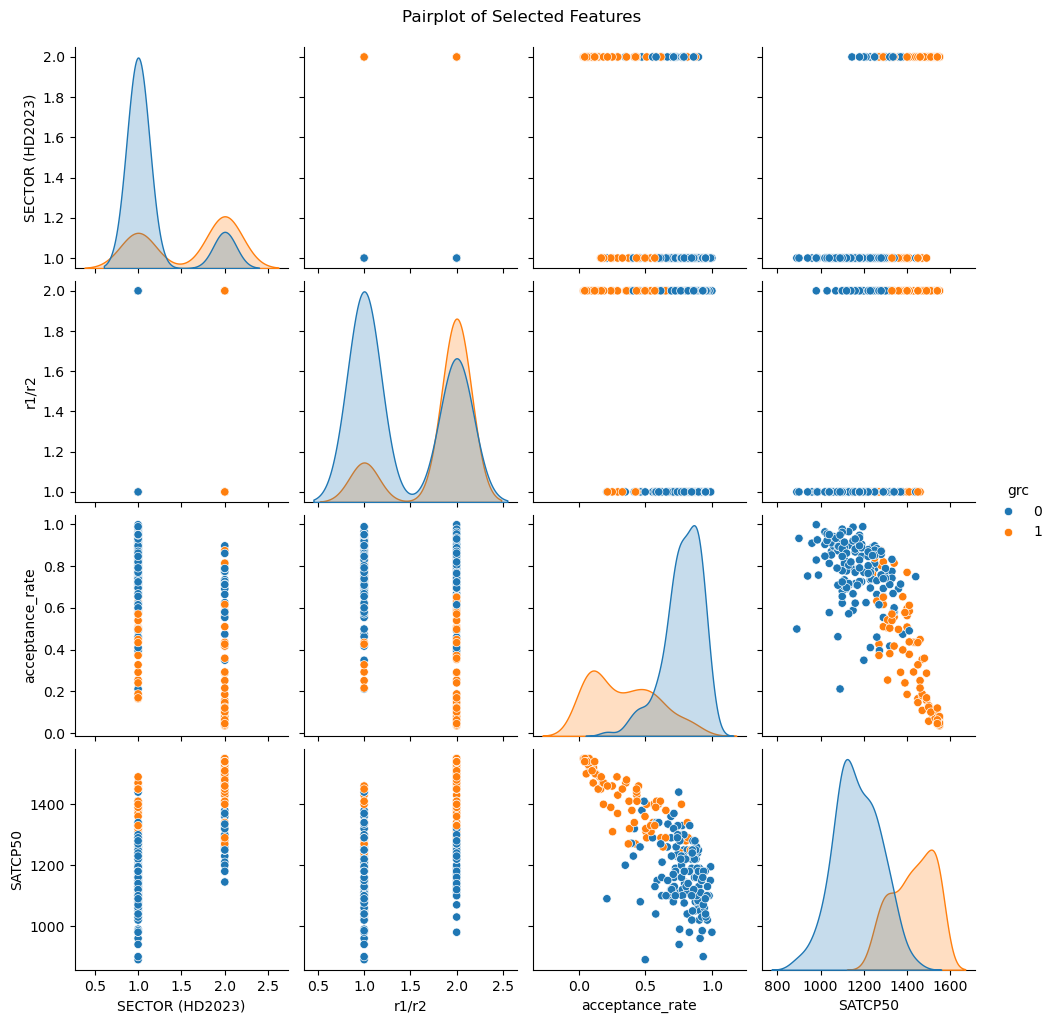

In [70]:
sns.pairplot(hgr_df, vars=['SECTOR (HD2023)','r1/r2','acceptance_rate','SATCP50'], hue='grc', diag_kind='kde')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

In [71]:
X = hgr_df[['SECTOR (HD2023)','r1/r2','acceptance_rate','SATCP50']]
y = hgr_df['grc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='linear',random_state=1)
svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9104477611940298
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.81      0.89      0.85        19

    accuracy                           0.91        67
   macro avg       0.88      0.91      0.89        67
weighted avg       0.91      0.91      0.91        67



In [72]:
cv_scores = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=10)
print(f"Mean CV Accuracy: {cv_scores.mean():.3f}")

Mean CV Accuracy: 0.865


3. Are there distinct clusters of institutions based on net cost of attendance and average test scores?

In [73]:
sr_fa_df = pd.read_csv("Datasets/question_3.csv")

sr_fa_df.drop(sr_fa_df.columns[5], axis=1, inplace=True)
sr_fa_df.dropna(inplace=True)

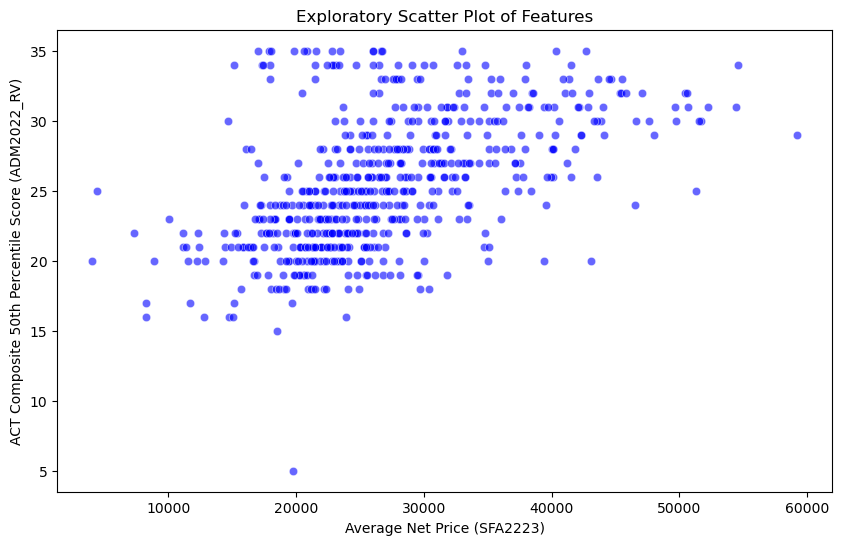

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sr_fa_df['Average net price-students awarded grant or scholarship aid  2022-23 (SFA2223)'],
                y=sr_fa_df['ACT Composite 50th percentile score (ADM2022_RV)'],
                data=sr_fa_df,
                alpha=0.6, color='blue')

plt.title('Exploratory Scatter Plot of Features')
plt.xlabel('Average Net Price (SFA2223)')
plt.ylabel('ACT Composite 50th Percentile Score (ADM2022_RV)')
plt.show()

In [75]:
X = sr_fa_df[['Average net price-students awarded grant or scholarship aid  2022-23 (SFA2223)',
              'ACT Composite 50th percentile score (ADM2022_RV)']].values

X_scaled = StandardScaler().fit_transform(X)

fitted_dbscan = DBSCAN(eps=0.24, min_samples=5).fit(X_scaled)

sr_fa_df['cluster'] = fitted_dbscan.labels_

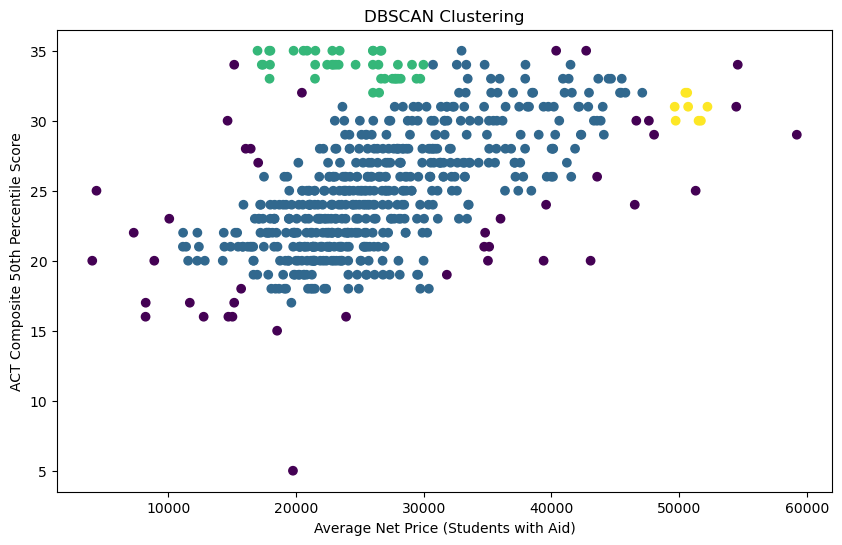

Number of clusters found: 3
Number of noise points: 42
504                  Baylor University
1670                   Emerson College
3583                   Oberlin College
3904             Pepperdine University
4023              Pratt Institute-Main
4419            Santa Clara University
4856               Syracuse University
5206    Tulane University of Louisiana
Name: Institution Name, dtype: object


In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=fitted_dbscan.labels_, cmap='viridis')
plt.xlabel('Average Net Price (Students with Aid)')
plt.ylabel('ACT Composite 50th Percentile Score')
plt.title('DBSCAN Clustering')
plt.show()

print(f"Number of clusters found: {len(set(fitted_dbscan.labels_)) - (1 if -1 in fitted_dbscan.labels_ else 0)}")
print(f"Number of noise points: {list(fitted_dbscan.labels_).count(-1)}")

colleges_in_cluster = sr_fa_df[sr_fa_df['cluster'] == 2]

print(colleges_in_cluster['Institution Name'])


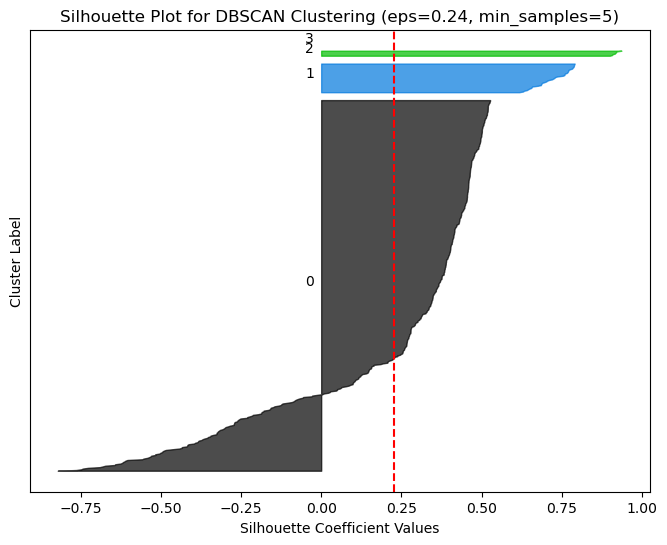

In [77]:
cluster_labels = sr_fa_df['cluster']
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

# Create silhouette plot
plt.figure(figsize=(8, 6))
y_lower = 10

for i in range(-1, n_clusters):
    if i == -1:
        continue

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for DBSCAN Clustering (eps=0.24, min_samples=5)")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])
plt.show()


In [78]:
noise_indices = [i for i, label in enumerate(fitted_dbscan.labels_) if label == -1]
print("Number of noise points:", len(noise_indices))

institutions = sr_fa_df.iloc[noise_indices]['Institution Name'].tolist()
act_cmp = sr_fa_df.iloc[noise_indices]['ACT Composite 50th percentile score (ADM2022_RV)'].tolist()
prices = sr_fa_df.iloc[noise_indices]['Average net price-students awarded grant or scholarship aid  2022-23 (SFA2223)'].tolist()

for institution, price, act in zip(institutions, prices,act_cmp):
    print(f"{institution}: {price}, ACT: {act}")


Number of noise points: 42
Baptist University of Florida: 8904.0, ACT: 20.0
Berea College: 4379.0, ACT: 25.0
Bethune-Cookman University: 14705.0, ACT: 16.0
Bloomfield College: 18522.0, ACT: 15.0
Brigham Young University: 14643.0, ACT: 30.0
Brigham Young University-Idaho: 7295.0, ACT: 22.0
Chapman University: 48037.0, ACT: 29.0
Colby College: 15163.0, ACT: 34.0
Columbia College: 23920.0, ACT: 16.0
Culinary Institute of America: 36015.0, ACT: 23.0
Davis & Elkins College: 19762.0, ACT: 5.0
Dominican University of California: 51292.0, ACT: 25.0
Fairfield University: 47630.0, ACT: 30.0
Franklin W Olin College of Engineering: 40370.0, ACT: 35.0
Gallaudet University: 15025.0, ACT: 16.0
Goshen College: 17040.0, ACT: 27.0
Harvey Mudd College: 42720.0, ACT: 35.0
High Point University: 43578.0, ACT: 26.0
Jewish Theological Seminary of America: 54588.0, ACT: 34.0
John Paul the Great Catholic University: 31811.0, ACT: 19.0
Kettering College: 4048.0, ACT: 20.0
LIM College: 39389.0, ACT: 20.0
Livings

4. Do graduation rates significantly differ between public and private institutions, controlling for factors like student demographics and institutional funding?
Technique: Regression (Multiple Linear Regression)
Why It’s Interesting: This question helps evaluate whether public and private institutions provide similar educational outcomes and if external factors contribute to graduation success rates.
